# Face13 Single Subject ERP Walkthrough

This notebook provides a walkthrough of initializing a single Face13 subject and plotting some basic ERP analysis.

Artifact detection is left for another time.

## High Level Imports

As expected, you will need to import MNE. The Path import is for convenience when reading and writing files.

The line setting the browser backend to `qt` provides responsive pop-out figures that can be interacted with. This may require extra `pip install` calls, as well as making sure QT itself is installed on your machine.

In [1]:
import mne
import json
import numpy as np
from pathlib import Path
mne.viz.set_browser_backend('qt')

Using qt as 2D backend.


## Loading Data

The function `single_subject_init` takes a List of BDF files to first downsample, and then concatenate.

If the recording already exists at the given static location, it loads that instead.

In [2]:
def single_subject_init(file_list, subject_label, downsample=256):
    out_path = f'projects/singletons/{subject_label}_raw.fif'
    if Path(out_path).is_file():
        print('File already exists at: ', out_path)
        return mne.io.read_raw_fif(out_path)
    
    raw = mne.io.read_raw_bdf(f'projects/Face13/sourcedata/{file_list[0]}')
    raw.resample(downsample, n_jobs=8)
    for file in file_list[1:]:
        print('Loading file: ', file)
        new_raw = mne.io.read_raw_bdf(f'projects/Face13/sourcedata/{file}')
        new_raw.resample(downsample, n_jobs=8)
        mne.io.concatenate_raws([raw, new_raw])

    raw.set_montage('biosemi128')
    raw.save(out_path)
    return raw

Initialization is done by passing `all_recordings` and a subject ID to the previously defined function.

In [3]:
all_recordings = ['IC_trn_P01_F_1.bdf','IC_trn_P01_F_2.bdf','IC_trn_P01_F_3.bdf','IC_trn_P01_F_4.bdf',
                  'IC_trn_P01_O_1.bdf','IC_trn_P01_O_2.bdf','IC_trn_P01_O_3.bdf','IC_trn_P01_O_4.bdf']

raw = single_subject_init(all_recordings, 'sub-01')
raw

File already exists at:  projects/singletons/sub-01_raw.fif
Opening raw data file projects/singletons/sub-01_raw.fif...
    Range : 0 ... 523519 =      0.000 ...  2044.996 secs
Ready.


<Raw | sub-01_raw.fif, 129 x 523520 (2045.0 s), ~181 kB, data not loaded>

MNE upon loading a file provides us with some basic summary information about the data we have just loaded.

More information can be found about `raw` objects [here](https://mne.tools/stable/generated/mne.io.Raw.html).

## Basic Exploration

An easy sanity check to make sure the data is really loaded can be achieved by computing and plotting the PSD.

The magic cell method `%matplotlib qt` ensures that a pop out figure will be created via QT. This will allow you to inspect channels, and see that the outlier channel in the below figure is `C10`

In [ ]:
%matplotlib qt
raw.compute_psd().plot()

The next sanity check would be to page through the data.

The reference for the plotting function can be found [here](https://mne.tools/stable/generated/mne.viz.plot_raw.html) and is powered by the [mne-qt-browser](https://github.com/mne-tools/mne-qt-browser).

**Note:** In my case I pass a theme because I run my setup in dark mode.

In [ ]:
%matplotlib qt
mne.viz.plot_raw(raw, theme='light')

## Working with Events

In general, MNE represent their events as a two-dimensional NumPy array as seen below in the `array` output.

In [4]:
events = mne.find_events(raw, initial_event=True)
events

7580 events found
Event IDs: [   11    12    13    14    15    16    21    22    23    24    25    26
    31    32    33    34    35    36    41    42    43    44    45    46
    51    52    53    54    55    56   201   204   211   212   213   214
   215   216 65536 65547 65548 65549 65550 65551 65552 65790 65791]


array([[     0,      0,  65536],
       [   253,  65536,  65790],
       [  1558,      0,     12],
       ...,
       [523146,      0,    201],
       [523233,      0,    212],
       [523472,      0,    213]])

The format is defined as follows from the MNE documentation:

> The first column contains the event onset (in samples) with first_samp included. The last column contains the event code. The second column contains the signal value of the immediately preceding sample, and reflects the fact that event arrays sometimes originate from analog voltage channels (“trigger channels” or “stim channels”). In most cases, the second column is all zeros and can be ignored.

Thus, one can quickly get a record of the first time an event is present in seconds:

In [ ]:
frontier = {}
for sample, duration, pin in mne.find_events(raw, initial_event=True):
    if pin not in frontier:
        frontier[pin] = sample / raw.info['sfreq'] # sampling rate to convert to seconds
frontier

By working backwards these were decoded and saved to a JSON file.

In [5]:
with open('projects/Face13/event_dict.json') as f:
    event_dict = json.loads(f.read())
event_dict

{'boundary': 65791,
 'anim/house/upright/f1': 11,
 'anim/house/upright/f2': 12,
 'anim/house/upright/f3': 13,
 'anim/house/upright/f4': 14,
 'anim/house/upright/f5': 15,
 'anim/house/upright/f6': 16,
 'anim/face/upright/f1': 31,
 'anim/face/upright/f2': 32,
 'anim/face/upright/f3': 33,
 'anim/face/upright/f4': 34,
 'anim/face/upright/f5': 35,
 'anim/face/upright/f6': 36,
 'house/inverted/f1': 21,
 'anim/house/inverted/f2': 22,
 'anim/house/inverted/f3': 23,
 'anim/house/inverted/f4': 24,
 'anim/house/inverted/f5': 25,
 'anim/house/inverted/f6': 26,
 'anim/checker/f1': 51,
 'anim/checker/f2': 52,
 'anim/checker/f3': 53,
 'anim/checker/f4': 54,
 'anim/checker/f5': 55,
 'anim/checker/f6': 56,
 'anim/face/inverted/f1': 41,
 'anim/face/inverted/f2': 42,
 'anim/face/inverted/f3': 43,
 'anim/face/inverted/f4': 44,
 'anim/face/inverted/f5': 45,
 'anim/face/inverted/f6': 46,
 'static/checker/left': 215,
 'press/left': 201,
 'static/checker/right': 216,
 'press/right': 204,
 'static/face/upright

More information about events and their heirarchical properties can be found in MNE's event reference [here](https://mne.tools/dev/auto_tutorials/raw/20_event_arrays.html).

Plotting this structure can be another strong sanity check.

In [ ]:
%matplotlib qt
fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], on_missing='ignore',
                          first_samp=raw.first_samp, event_id=event_dict)
fig.subplots_adjust(right=0.7)  # make room for legend

# Epoching your Data

Assuming your data is clean and you are happy with it, you can move on to epoching.

The `raw` object can be removed from memory at this point as we are only concerned with `Epochs` from now on.

In [6]:
epochs = mne.Epochs(raw, events, tmin=-1.0, tmax=2.0, event_id=event_dict, preload=True)
del raw
epochs

Not setting metadata
7563 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 7563 events and 769 original time points ...
5 bad epochs dropped


Number of events,7558
Events,anim/checker/f1: 200anim/checker/f2: 200anim/checker/f3: 200anim/checker/f4: 200anim/checker/f5: 200anim/checker/f6: 200anim/face/inverted/f1: 200anim/face/inverted/f2: 200anim/face/inverted/f3: 200anim/face/inverted/f4: 200anim/face/inverted/f5: 200anim/face/inverted/f6: 200anim/face/upright/f1: 199anim/face/upright/f2: 199anim/face/upright/f3: 199anim/face/upright/f4: 199anim/face/upright/f5: 199anim/face/upright/f6: 199anim/house/inverted/f2: 199anim/house/inverted/f3: 199anim/house/inverted/f4: 199anim/house/inverted/f5: 199anim/house/inverted/f6: 199anim/house/upright/f1: 198anim/house/upright/f2: 199anim/house/upright/f3: 199anim/house/upright/f4: 199anim/house/upright/f5: 199anim/house/upright/f6: 199boundary: 0house/inverted/f1: 199press/left: 194press/right: 200static/checker/left: 197static/checker/right: 197static/face/inverted: 197static/face/upright: 198static/house/inverted: 197static/house/upright: 197
Time range,-1.000 – 2.000 sec
Baseline,-1.000 – 0.000 sec


Based on the summary, we can see that the input functions allows us to easily control the time range and baseline. For more arguments, see [here](https://mne.tools/stable/generated/mne.Epochs.html).

Next, we will select the conditions we are interested in based on MNE's heirarchical approach.

In [7]:
condition_face = 'static/face'
condition_house = 'static/house'
print(epochs[[condition_face, condition_house]])

<Epochs |  789 events (all good), -1 - 2 sec, baseline -1 – 0 sec, ~597.3 MB, data loaded,
 'static/face/upright': 198
 'static/face/inverted': 197
 'static/house/upright': 197
 'static/house/inverted': 197>


This confirms that we likely have enough trials to see an ERP in the given conditions. Note that it selected both `upright` and `inverted` as they are nested deeper in the naming tree.

If there is a trial cap concern, the following code snippet would balance the trial counts:

```Python
conds_we_care_about = ['target', 'nontarget']
epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
```

Next, the conditions are averaged together across trials.

In [8]:
faces = epochs[condition_face].average()
houses = epochs[condition_house].average()

Finally, the epochs can be compared.

The following plots the channels in the `picks` List averaged togther:

combining channels using "mean"
combining channels using "mean"


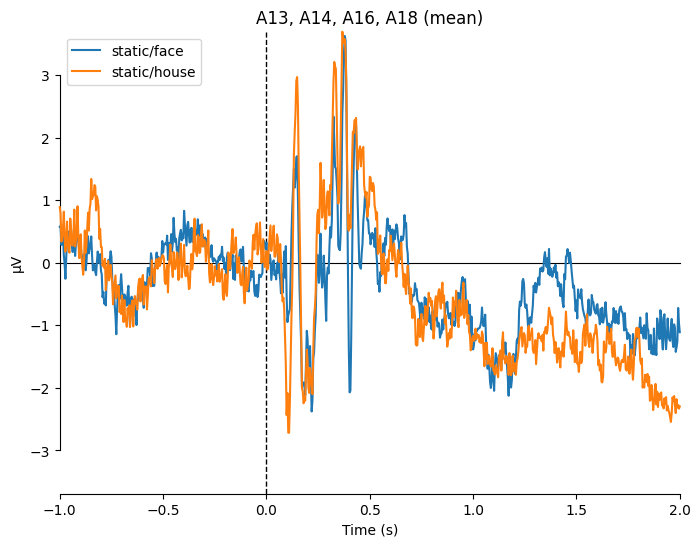

[<Figure size 800x600 with 1 Axes>]

In [9]:
picks = ['A13', 'A14', 'A16', 'A18']
evokeds = {condition_face: faces, condition_house: houses}
mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine='mean')

The GFP can be computed via a trimmed standard deviation as such:

combining channels using "<function <lambda> at 0x7fefcb8e9000>"
combining channels using "<function <lambda> at 0x7fefcb8e9000>"


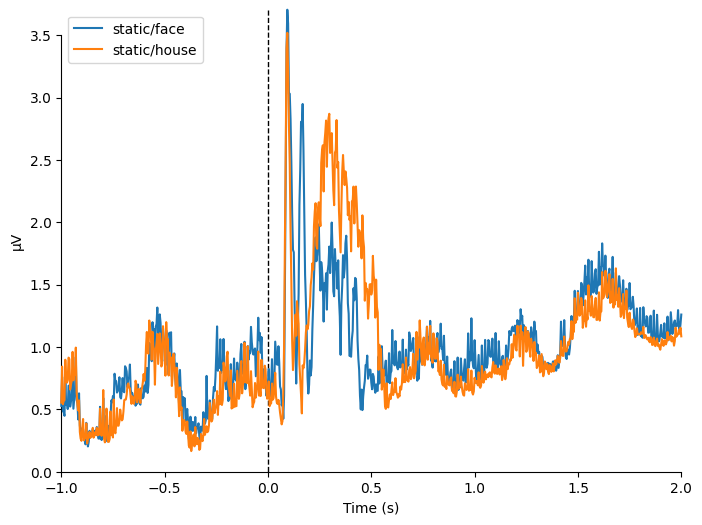

[<Figure size 800x600 with 1 Axes>]

In [10]:
from scipy.stats.mstats import trimmed_std
combine = lambda data: trimmed_std(data, limits=(0.2, 0.2), axis=1)
mne.viz.plot_compare_evokeds(evokeds, picks=None, combine=combine)

Confidence intervals are computed similarly, with a different evoked object:

combining channels using "mean"
combining channels using "mean"


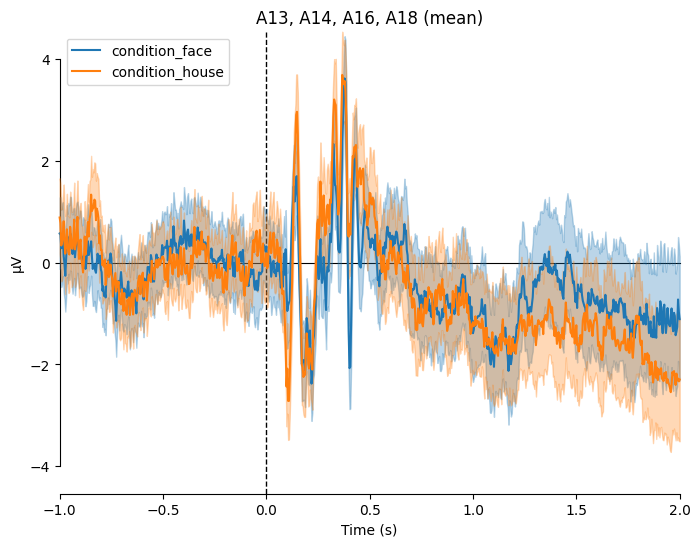

[<Figure size 800x600 with 1 Axes>]

In [20]:
evokeds = dict(condition_face=list(epochs[condition_face].iter_evoked()),
               condition_house=list(epochs[condition_house].iter_evoked()))
mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine='mean')